## Imports

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os 
import tqdm
import argparse
import wandb
from time import time
import datetime
import sys

import torch
import torch.nn as nn
import torchvision
import PIL
from PIL import Image
import torchvision.transforms as transforms
import torch.optim as optim
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

c:\Users\Ayush\anaconda3\envs\pytorch\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


## Data Utilities
1. Image loading and saving utilities
2. Data Augmentation
3. Splitting the data into train and validation sets
4. Custom Dataset and Dataloaders


### 1. Image loading and saving utilities

In [5]:
def load_image(img_path):
    img = Image.open(img_path)
    img = img.convert('RGB')
    img_arr = np.array(img)
    return img_arr

In [6]:
def save_image(img_arr, img_path):
    img = Image.fromarray(img_arr)
    img.save(img_path)

### 2. Data Augmentation
![data_aug](markdown_file/data_augmentation.png)

In [7]:
train_transform = A.Compose([
    A.Resize(width=528, height=528), # changing to 528x528
    A.RandomCrop(width=48, height=48), # randomly cropping patches of 48x48
    A.Rotate(limit=20, p=0.5), # geometric transformation
    A.GaussNoise(p=0.5), # adding noise
    A.GaussianBlur(p=0.5), # smoothing
    A.RandomBrightnessContrast(p=0.5), # changing perturbations
    ToTensorV2() # converting to tensor
])


# will be using sliding window technique to generate prediction for full images during validation
val_transform = A.Compose([
    A.Resize(width=528, height=528),
    ToTensorV2()
])
    
    

### 3. Splitting the data into train and validation sets

In [5]:
def split(images_path, masks_path, train_size=0.9, random_state=42):
    num_samples = int(train_size*len(os.listdir(images_path)))
    images_list = np.array(os.listdir(images_path))
    mask_list = np.array(os.listdir(masks_path))

    indices = np.arange(len(os.listdir(images_path)))
    np.random.seed(random_state)
    train_indices = np.random.choice(indices, num_samples, replace=False)
    val_indices = np.array(list(set(indices) - set(train_indices)))
    return list(images_list[train_indices]), list(images_list[val_indices]), list(
        mask_list[train_indices]), list(mask_list[val_indices])

### 4. Custom Dataset and Dataloaders

In [6]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, images_dir, masks_dir, images_list, masks_list, transform=None,
                 mode='train', max_samples=1000):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.images_list = images_list
        self.masks_list = masks_list
        self.transform = transform
        self.mode = mode
        self.max_samples = max_samples

    def __len__(self):
        if self.mode == 'train':
            return max(self.max_samples, len(self.images_list))
        else:
            return len(self.images_list)
    
    def __getitem__(self, idx):
        if self.mode == 'train':
            idx = idx%len(self.images_list)
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = self.images_list[idx].replace('training.tif', 'manual1.gif')
        mask_path = os.path.join(self.masks_dir, mask_path)

        img_arr = load_image(img_path)
        mask_arr = load_image(mask_path)
        mask_arr = mask_arr[:,:,0]
        mask_arr[mask_arr==255] = 1

        if self.transform is not None:
            transformed = self.transform(image=img_arr, mask=mask_arr)
            img_arr = transformed['image']
            mask_arr = transformed['mask']
        
        return {'img':img_arr, 'mask':mask_arr}

In [7]:
images_paths, masks_paths = 'data/DRIVE/training/images', 'data/DRIVE/training/1st_manual'  
train_images_list, val_images_split, train_masks_list, val_masks_list = split(
    images_paths, masks_paths)

1000


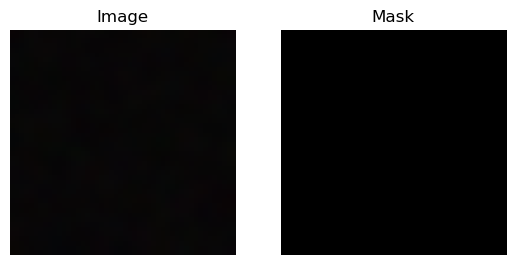

In [8]:
train_dataset = CustomDataset(images_dir=images_paths, masks_dir=masks_paths, images_list=train_images_list, 
                              masks_list=train_masks_list,
                              mode='train',
                              transform=train_transform)

print(len(train_dataset))
idx = 10
img_arr, mask_arr = train_dataset[idx]['img'], train_dataset[idx]['mask']


plt.subplot(1,2,1)
plt.imshow(img_arr.numpy().transpose(1,2,0))
plt.title('Image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(mask_arr.numpy(), cmap='gray')
plt.title('Mask') 
plt.axis('off')
plt.show()

2
torch.Size([3, 528, 528]) torch.Size([528, 528])


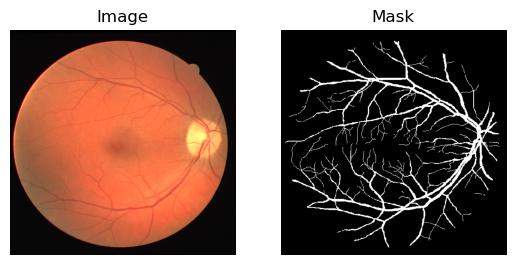

In [9]:
val_dataset = CustomDataset(images_dir=images_paths, masks_dir=masks_paths, images_list=val_images_split, 
                            masks_list=val_masks_list,
                            mode='val',
                            transform=val_transform)

print(len(val_dataset))
idx = 0
img_arr, mask_arr = val_dataset[idx]['img'], val_dataset[idx]['mask']
print(img_arr.shape, mask_arr.shape)

plt.subplot(1,2,1)
plt.imshow(img_arr.numpy().transpose(1,2,0))
plt.title('Image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(mask_arr.numpy(), cmap='gray')
plt.title('Mask')
plt.axis('off')
plt.show()


In [10]:
# now the data loader part
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
print(len(train_loader), len(val_loader))

# now we want to apply progress bar through tqdm
batches = tqdm.tqdm(enumerate(train_loader, 0), 'sanity_check', total = len(train_loader), colour='blue')
for i, batch in batches:
    batches.set_postfix({'a':batch['img'].shape,'b':batch['mask'].shape})

32 2


sanity_check: 100%|██████████| 32/32 [00:15<00:00,  2.13it/s, a=torch.Size([8, 3, 48, 48]), b=torch.Size([8, 48, 48])]  


## Model Implementation
1. ResnetBlock
2. Squeeze and Excitation Block
3. Fusion Upsampling Module
4. Dynamic Receptive Field Module
5. Super-UNET architecture:
    - Downsample
    - Upsample
    - Full Architecture

### 1. ResnetBlock
![resblock](markdown_file/res_block.png)

In [11]:
class resblock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(resblock, self).__init__()
        self.skip_conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()


    def forward(self, x):
        # this is the skip connection part
        residual = x # shape (B, in_C, H, W)
        residual = self.skip_conv(residual) # shape (B, out_C, H, W)

        # this is the main part
        out = self.conv1(x) # shape (B, out_C, H, W)
        out = self.bn1(out) # shape (B, out_C, H, W)
        out = self.relu(out) # shape (B, out_C, H, W)
        out = self.conv2(out)  # shape (B, out_C, H, W)
        out += residual # shape (B, out_C, H, W)
        out = self.bn2(out)
        out = self.relu(out)
        return out


In [12]:
# test_res = resblock(3, 8)
# print(test_res)
# x = torch.randn(1, 3, 48, 48)
# out = test_res(x)
# print(out.shape)

### 2. Squeeze and Excitation Block
![seblock](markdown_file/image.png)

In [13]:
class squeeze_and_excitation(nn.Module):
    def __init__(self, in_channels, r=2):
        super(squeeze_and_excitation, self).__init__()
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(in_channels, in_channels//r)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(in_channels//r, in_channels)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # shape is (B, in_C, H, W)
        orig = x.clone() # shape is (B, in_C, H, W)
        out = self.global_pool(x) # shape is (B, in_C, 1, 1)
        out = out.view(out.size(0), -1)
        out = self.fc1(out) # shape is (B, in_C//r)
        out = self.relu(out) # shape is (B, in_C//r)
        out = self.fc2(out) # shape is (B, in_C)
        out = self.sigmoid(out) # shape is (B, in_C)
        out = out.view(out.size(0), out.size(1), 1, 1) # shape is (B, in_C, 1, 1)
        out = orig * out # shape is (B, in_C, H, W)
        return out


In [14]:
# test_se = squeeze_and_excitation(8, 2)
# print(test_se)
# x = torch.randn(1, 8, 48, 48)
# out = test_se(x)
# print(out.shape)


### 3. Fusion Upsampling Module
![fum](markdown_file/fum.png)

In [15]:
class fusion_upsampling(nn.Module):
    def __init__(self, enc_C, dec_C, r=2):
        super(fusion_upsampling, self).__init__()
        # assert enc_C == dec_C//2, "enc_C should be equal to dec_C//2"
        # se modules for encoder and decoder
        self.enc_se = squeeze_and_excitation(enc_C, r)
        self.dec_se = squeeze_and_excitation(dec_C, r)

        # upsampling part
        self.conv_tr = nn.ConvTranspose2d(dec_C, enc_C, kernel_size=2, stride=2)
        self.bn = nn.BatchNorm2d(enc_C)
        self.relu = nn.ReLU()


    def forward(self, enc_map, dec_map):
        # enc_map shape is (B, enc_C, 2*H, 2*W)
        # dec_map shape is (B, 2*enc_C, H, W) (dec_C = 2*enc_C)
        # se part
        enc_map = self.enc_se(enc_map) # shape is (B, enc_C, 2*H, 2*W)
        dec_map = self.dec_se(dec_map) # shape is (B, 2*enc_C, H, W)

        # upsampling part
        dec_map = self.conv_tr(dec_map) # shape is (B, enc_C, 2*H, 2*W)
        dec_map = self.bn(dec_map) # shape is (B, enc_C, 2*H, 2*W)
        dec_map = self.relu(dec_map) # shape is (B, enc_C, 2*H, 2*W)

        # fusion part
        out = torch.concat((enc_map, dec_map), dim=1) # shape is (B, 2*enc_C, 2*H, 2*W)
        return out

In [16]:
# test_frm = fusion_upsampling(8, 16, 2)
# print(test_frm)
# enc_map = torch.randn(1, 8, 48, 48)
# dec_map = torch.randn(1, 16, 24, 24)
# out = test_frm(enc_map, dec_map)
# print(out.shape)

### 4. Dynamic Receptive Field Module
- sizes can't be handled due to concat, so instead of concatenation in the last step, i'm gonna add them up or adding an extra convolution after the drfm module to half the number of channels
![drfm](markdown_file/drfm.png)

In [17]:
class dynamic_receptive_field_module(nn.Module):
    def __init__(self, in_C):
        super(dynamic_receptive_field_module, self).__init__()
        self.conv1x1 = nn.Conv2d(in_C, in_C, kernel_size=1, stride=1, padding='same')
        self.conv3x3 = nn.Conv2d(in_C, in_C, kernel_size=3, stride=1, padding='same')
        self.conv5x5 = nn.Conv2d(in_C, in_C, kernel_size=5, stride=1, padding='same')

        self.conv1x1_dil = nn.Conv2d(in_C, in_C, kernel_size=1, stride=1, padding='same', dilation=1)
        self.conv3x3_dil = nn.Conv2d(in_C, in_C, kernel_size=3, stride=1, padding='same', dilation=3)
        self.conv5x5_dil = nn.Conv2d(in_C, in_C, kernel_size=5, stride=1, padding='same', dilation=5)
        

        # self.final_conv = nn.Conv2d(3*in_C, in_C, kernel_size=3, stride=1, padding='same')
        # self.bn = nn.BatchNorm2d(in_C)

        self.last_conv1 = nn.Conv2d(3*in_C, in_C, kernel_size=3, stride=1, padding='same')
        self.bn1 = nn.BatchNorm2d(in_C)
        self.relu = nn.ReLU()

        self.last_conv2 = nn.Conv2d(2*in_C, in_C, kernel_size=3, stride=1, padding='same')
        self.bn2 = nn.BatchNorm2d(in_C)


    def forward(self, x):
        # x shape is (B, in_C, H, W)
        orig = x.clone()
        # 1x1 conv part
        out_1 = self.conv1x1(x) # shape is (B, in_C, H, W)
        out_1 = self.conv1x1_dil(out_1) # shape is (B, in_C, H, W)
        # 3x3 conv part
        out_3 = self.conv3x3(x)
        out_3 = self.conv3x3_dil(out_3)
        # 5x5 conv part
        out_5 = self.conv5x5(x)
        out_5 = self.conv5x5_dil(out_5)
        # concat all the outputs
        out = torch.cat((out_1, out_3, out_5), dim=1) # shape is (B, 3*in_C, H, W)
        out = self.last_conv1(out) # shape is (B, in_C, H, W)
        out = self.bn1(out) # shape is (B, in_C, H, W)
        out = self.relu(out) # shape is (B, in_C, H, W)

        # skip connection
        out = torch.cat((orig, out), dim=1) # shape is (B, 2*in_C, H, W)

        # last convolution to get the half number of channels
        out = self.last_conv2(out) # shape is (B, in_C, H, W)
        out = self.bn2(out) # shape is (B, in_C, H, W)
        out = self.relu(out) # shape is (B, in_C, H, W)




        # # skip connection
        # out = self.final_conv(out) # shape is (B, in_C, H, W)
        # out = self.bn(out) # shape is (B, in_C, H, W)
        # out = self.relu(out) # shape is (B, in_C, H, W)

        # # skip connection
        # # out = torch.cat((orig, out), dim=1) # shape is (B, 2*in_C, H, W)
        # out+= orig # shape is (B, in_C, H, W)

        return out

In [18]:
# test_drfm = dynamic_receptive_field_module(8)
# print(test_drfm)
# x = torch.randn(1, 8, 48, 48)
# out = test_drfm(x)
# print(out.shape)

### 5. Super-UNET architecture
![superunet](markdown_file/superunet.png)

In [19]:
class downsample(nn.Module):
    def __init__(self, channels = [3, 8, 16, 32, 64, 128]):
        super(downsample, self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.channels = channels
        self.blocks = nn.ModuleList([])
        for i in range(5):
            self.blocks.append(resblock(self.channels[i], self.channels[i+1]))
        self.skips = []
        pass

    def forward(self, x):
        # x shape is (B, 3, H, W)
        for i in range(5):
            x = self.blocks[i](x) # (B, channels[i+1], H, W)
            self.skips.append(x) # (B, channels[i+1], H, W)
            if i < 4:
                x = self.pool(x) # (B, channels[i+1], H/2, W/2)
        return self.skips

In [20]:
# device = 'cuda'
# test_down = downsample().to(device)
# print(test_down)
# x = torch.randn(1, 3, 48, 48).to(device)
# skips = test_down(x)
# print(len(skips))
# for i in range(len(skips)):
#     print(skips[i].shape)

In [21]:
class upsample(nn.Module):
    def __init__(self, channels = [128, 64, 32, 16, 8, 3]):
        super(upsample, self).__init__()
        self.channels = channels
        self.frm_blocks = nn.ModuleList([])
        self.res_blocks = nn.ModuleList([])
        self.drfm_blocks = nn.ModuleList([])
        for i in range(4):
            self.frm_blocks.append(fusion_upsampling(self.channels[i+1], self.channels[i]))
            self.res_blocks.append(resblock(self.channels[i], self.channels[i+1]))
            self.drfm_blocks.append(dynamic_receptive_field_module(self.channels[i+1]))
        


    def forward(self, skips):
        dec_map = skips[-1] # (B, 128, 3, 3)
        for i in range(4):
            enc_map = skips[-i-2] # (B, channels[i+1], 2**i*H, 2**i*W)
            dec_map = self.frm_blocks[i](enc_map, dec_map) # (B, channels[i], 2**i*H, 2**i*W)
            dec_map = self.res_blocks[i](dec_map) # (B, channels[i+1], 2**i*H, 2**i*W)
            dec_map = self.drfm_blocks[i](dec_map) # (B, channels[i+1], 2**i*H, 2**i*W)

    
        return dec_map



In [22]:
# test_up = upsample()
# print(test_up)
# out = test_up(skips)
# print(out.shape)

In [23]:
class SuperUNET(nn.Module):
    def __init__(self, num_classes = 2):
        super(SuperUNET, self).__init__()
        self.down = downsample()
        self.up = upsample()
        self.conv1x1 = nn.Conv2d(8, num_classes, kernel_size=1, stride=1)

    def forward(self, x):
        # x shape is (B, 3, H, W)
        skips = self.down(x) # all the skip connections
        out = self.up(skips)
        out = self.conv1x1(out)
        return out



In [24]:
# device = 'cuda'
# test_sunet = SuperUNET().to(device)
# loss_fn = nn.CrossEntropyLoss()
# image = torch.randn(1, 3, 48, 48).to(device)
# target = torch.randint(0, 2, (1, 48, 48)).to(device)
# out = test_sunet(image)
# print(out.shape)
# print(loss_fn(out, target))

## Model Utilities
1. Save Model
2. Load Model

In [25]:
def save_model(model, optimizer, epoch, loss, path):
    # we are savinf optimizer and epoch also so that we can resume training from the same point if required 
    # otherwise we will just save the model state_dict
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'loss': loss
    }, path)

In [26]:
def load_model(model, optimizer, path):
    # after returning the model, optimizer, epoch and loss, we can resume training from the same point
    # or we can use the model for inference
    # so use model.train() and model.eval() with torch.inference_mode(): as required
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    return model, optimizer, epoch, loss

In [27]:
# model = test_sunet
# lr, weight_decay = 1e-3, 1e-5
# optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
# epochs = 2
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# model.to(device)

## Metrics and loss function
1. Accuracy
2. Positive Predictive Value
3. Sensitivity
4. Dice Coefficient

In [55]:
def metrics(pred, target):
    # since this is all about binary segmentation maps, we will be using confusion marix
    # pred shape is (B, num_classes, H, W)
    # target shape is (B, H, W)
    pred = pred.argmax(dim=1) # (B, H, W)
    target = target.long()
    eps = 1e-7
    true_positive = torch.bitwise_and(pred==1, target==1).sum().item() + eps
    true_negative = torch.bitwise_and(pred==0, target==0).sum().item() + eps
    false_positive = torch.bitwise_and(pred==1, target==0).sum().item() + eps
    false_negative = torch.bitwise_and(pred==0, target==1).sum().item() + eps

    all_pixels = true_positive + true_negative + false_positive + false_negative
    accuracy = (true_positive + true_negative)/all_pixels
    positive_predictive_rate = true_positive/(true_positive + false_positive)
    sensitivity = true_positive/(true_positive + false_negative)
    dice_similarity = 2*true_positive/(2*true_positive + false_positive + false_negative)


    return {'acc':accuracy, 'ppr':positive_predictive_rate, 'sens':sensitivity, 'dsc':dice_similarity}


## Training and prediction loops
1. Image segmentation (images to be segmented being of shape 528x528 while trained on 48x48) and visualization
2. Extra Things to consider in training loop
    - Done
        - Scheduler (Cosine Annealing with linear warmup)
        - Model Checkpointing
        - Mixed Precision Training
        - Gradient Clipping
        - Early Stopping
        - Logging
    - Wandb Integration
    - Multi-GPU Training
    

In [29]:
def segment(img, model, num_classes=2, device='cuda'):
    '''
    - we can multiple images at the same time, thus it works in the batched format
    '''
    model.eval()
    with torch.inference_mode():
        img = img.type(torch.float32).to(device)
        # orginally we segmented the images of size 48x48, but
        # now we are getting the images of size 528x528, so we will use sliding window technique
        # to generate the segmentation maps
        segmaps = torch.zeros((img.shape[0], num_classes, 528, 528)).to(device)
        # we will generate the segmentation maps for 11x11 patches of 48x48
        iters = tqdm.tqdm(range(121), 'generating patches', colour='yellow')
        for i in iters: # iterating over number of patches
            row, col = (i//11)*48, (i%11)*48
            img_patch = img[:,:,row:row+48, col:col+48]
            segmaps_patch = model(img_patch)
            segmaps[:,:,row:row+48, col:col+48] = segmaps_patch

        
        return segmaps


In [30]:
def visualize_segmaps(img_batch, segmap, orig_mask):
    '''
    - this too work in the batched form
    - we will do this with batch sizes of 4
    '''
    batch_size = img_batch.shape[0]
    plt.figure(figsize=(10,10))
    for i in range(batch_size):
        plt.subplot(batch_size, 3, 3*i + 1)
        plt.imshow(img_batch[i].detach().cpu().numpy().transpose(1,2,0))
        plt.title('Image')
        plt.axis('off')

        plt.subplot(batch_size, 3, 3*i + 2)
        plt.imshow(segmap[i].argmax(0).detach().cpu().numpy(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

        plt.subplot(batch_size, 3, 3*i + 3)
        plt.imshow(orig_mask[i].detach().cpu().numpy(), cmap='gray')
        plt.title('Original Mask')
        plt.axis('off')

    plt.show()

In [31]:
def save_segmaps(img_batch, segmap, orig_mask, path):
    '''
    - this too work in the batched form
    - we will do this with batch sizes of 4
    '''
    batch_size = img_batch.shape[0]
    for i in range(batch_size):
        plt.figure(figsize=(10,10))
        plt.subplot(1, 3, 1)
        plt.imshow(img_batch[i].detach().cpu().numpy().transpose(1,2,0))
        plt.title('Image')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(segmap[i].argmax(0).detach().cpu().numpy(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(orig_mask[i].detach().cpu().numpy(), cmap='gray')
        plt.title('Original Mask')
        plt.axis('off')

        plt.savefig(path)
        plt.close()

In [60]:
def time_elapsed(start_time):
    end_time = time()
    elapsed_time = end_time - start_time
    # let us change it to hours minutes and seconds manuaaly
    hours = int(elapsed_time//3600)
    minutes = int((elapsed_time%3600)//60)
    seconds = int(elapsed_time%60)
    elapsed_time = f'{hours}H {minutes}M {seconds}S'
    return elapsed_time

In [48]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = SuperUNET().to(device)
# lr, weight_decay = 1e-3, 1e-5
# optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
# scaler = torch.cuda.amp.GradScaler()
# epochs = 2
# loss_fn = nn.CrossEntropyLoss()

In [49]:
# let us first create a expts directory which will contains record of all of the expts
all_expts = os.makedirs('all_expts', exist_ok=True)
from datetime import datetime
t_init = str(datetime.now())
t_init = t_init.replace(' ', '_')
t_init = t_init.replace(':', '_')
t_init = t_init.replace('-', '_')
t_init = t_init.split('.')[0]
expt_name = f'expt_{t_init}'

# now we will create a directory for this expt
expt_dir = os.path.join('all_expts', expt_name)
os.makedirs(expt_dir, exist_ok=True)

folders_to_create = ['models', 'logs', 'test_images']
for folder in folders_to_create:
    folder = os.path.join(expt_dir, folder)
    os.makedirs(folder, exist_ok=True)

model_ckpt_dir = os.path.join(expt_dir, 'models')
model_ckpt_path = os.path.join(model_ckpt_dir, 'best_model.pth')
logs_dir = os.path.join(expt_dir, 'logs')
logs_path = os.path.join(logs_dir, 'logs.csv')
test_images_dir = os.path.join(expt_dir, 'test_images')
conifg_path = os.path.join(expt_dir, 'config.json')



In [50]:
import json
config = {
    # model names and saving paths
    'model':model.__class__.__name__,
    'optimizer':optimizer.__class__.__name__,
    'loss_fn':loss_fn.__class__.__name__,
    'model_ckpt_path':model_ckpt_path,
    'logs_path':logs_path,
    'test_images_dir':test_images_dir,

    # data args and model ars
    'batch_size':None,
    'lr':None,
    'weight_decay':None,
    'device':device.type,
    'epochs':None,
    'init_lr':None, # required in scheduler in case of warm starts
    'warmup_steps':None, # required in scheduler in case of warm starts 
    'total_steps':None, # required in scheduler in case of warm starts
    'amp':None, # automated mixed precision
    'gradient_clip':None,
    'early_stopping':None, # if applied it will be applied to model only
    'num_classes':2
}

def save_config(config_dict, config_path):
    with open(config_path, 'w') as f:
        json.dump(config_dict, f, indent=4)

In [51]:
def Cosine_Annealing_LinearWarmup_Scheduler(optimizer, init_lr, max_lr, 
                                            warmup_steps, global_step, total_steps):
    '''
    - init_lr is the initial learning rate
    - max_lr is the the learning rate which will achieved after the initial warmup
    - warmup_steps is the number of steps taken to reach the max_lr from init_lr
    - global_step is the current step number in the epoch
    - total_steps = 

    '''
    
    if global_step < warmup_steps:
        lr = init_lr + (max_lr - init_lr)*global_step/warmup_steps
    else:
        lr = init_lr + 0.5*(max_lr - init_lr)*(1 + np.cos((global_step - warmup_steps)/(total_steps - warmup_steps)*np.pi))


    optimizer.param_groups[0]['lr'] = lr


In [72]:
config['train_batch_size'] = 32
config['val_batch_size'] = 4
config['lr'] = 1e-3
config['weight_decay'] = 1e-5
config['device'] = 'cuda'
config['epochs'] = 20
config['init_lr'] = 0.0
config['warmup_steps'] = 10
config['total_steps'] = 1000
config['gradient_clip'] = 5.0
config['num_classes'] = 2
config['weights'] = [1, 4] # in loss function predicting 1 is 4 times more important than predicting 0

config['amp'] = True
config['early_stopping'] = False



In [ ]:
model = SuperUNET().to(config['device'])
lr, weight_decay = config['lr'], config['weight_decay']
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scaler = torch.cuda.amp.GradScaler()
epochs = config['epochs']
weights = torch.tensor(config['weights']).type(torch.float32).to(config['device'])
loss_fn = nn.CrossEntropyLoss(weight=weights)

In [77]:
def train(model, optimizer, loss_fn, config, train_loader, val_loader, scaler = None):
    start_time = time()
    global_step = 0 # to be used for learning rate scheduling
    best_loss = np.inf # to be used for model checkpointing, to be stored for lowest train loss
    train_performance_metrics = [] # to be used for training logs
    val_performance_metrics = [] # to be used for validation logs
    prev_val_loss = np.inf # to be used for early stopping, applied on train loss only
    counter = 0 # to be used for early stopping, applied on train loss only

    for epoch in range(config['epochs']):
        print(f'Epoch: {epoch+1}/{config["epochs"]}')
        model.train()
        # setting up the learning rate for this step
        Cosine_Annealing_LinearWarmup_Scheduler(optimizer, config['init_lr'], config['lr'], 
                                                config['warmup_steps'], global_step, config['total_steps'])
        epoch_train_performance_metrics = {'loss':0.0, 'acc':0.0, 'ppr':0.0, 'sens':0.0, 'dsc':0.0}
        epoch_val_performance_metrics = {'loss':0.0, 'acc':0.0, 'ppr':0.0, 'sens':0.0, 'dsc':0.0}

        batches = tqdm.tqdm(enumerate(train_loader, 0), 'training', total=len(train_loader), colour='green')
        for i, batch in batches:
            optimizer.zero_grad()
            imgs, masks = batch['img'].type(torch.float32).to(device), batch['mask'].type(torch.long).to(device)

            # forward pass
            op = model(imgs)
            loss = loss_fn(op, masks)
            epoch_train_performance_metrics['loss'] += loss.item()

            # backward pass
            if scaler is not None:
                # using automated mixed precision
                scaler.scale(loss).backward()
                # gradient clipping to avoid exploding gradients
                if config['gradient_clip'] is not None:
                    scaler.unscale_(optimizer)
                    torch.nn.utils.clip_grad_norm_(model.parameters(), config['gradient_clip'])
                
                scaler.step(optimizer)
                scaler.update()
            else:
                # without automated mixed precision
                loss.backward()
                # gradient clipping to avoid exploding gradients
                if config['gradient_clip'] is not None:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), config['gradient_clip'])
                optimizer.step()

            # logging
            global_step += 1
            batches.set_postfix({'loss':loss.item()})
            batch_metrics = metrics(op, masks)
            for key in batch_metrics.keys():
                epoch_train_performance_metrics[key] += batch_metrics[key]

            # now model checkpointing (model checkpointing is done on the global_step)
            # dividing the loss by number of images to get the average loss per image of the batch
            # as the batch size can be different
            if loss.item()/imgs.shape[0] < best_loss:
                best_loss = loss.item()/imgs.shape[0]
                save_model(model, optimizer, epoch, loss, config['model_ckpt_path'])
            
            # early stopping based on train loss if not improved from past 5 epochs or given number of early stopping epochs
            if config['early_stopping'] is not None and loss.item()/imgs.shape[0] > prev_val_loss:
                counter += 1
                if counter == config['early_stopping']:
                    counter = -1
                    break
            else:
                counter = 0

        if counter == -1:
            # now goes the early stopping
            print(f"-------/nEarly Stopping as loss not improved from past {config['early_stopping']} epochs/n-------")
            break
        

        # now all the stuff related to training has been done
        # now we will do the validation part, model.eval() and with torch.no_inference() has 
        # alredy been written in the segment function
        for i, batch in enumerate(val_loader):
            imgs, masks = batch['img'].type(torch.float32).to(device), batch['mask'].type(torch.long).to(device)
            op = segment(imgs, model, config['num_classes'], device)
            loss = loss_fn(op, masks)
            epoch_val_performance_metrics['loss'] += loss.item()
            batch_metrics = metrics(op, masks)

            for key in batch_metrics.keys():
                epoch_val_performance_metrics[key] += batch_metrics[key]

            # now we can log images for visual purposes
            segmap_path = os.path.join(config['test_images_dir'], f'segmap_{epoch}_{i}.png')
            save_segmaps(batch['img'].to(device), op, masks, segmap_path)
            


        # logging the epoch performance metrics
        for key in epoch_train_performance_metrics.keys():
            epoch_train_performance_metrics[key] /= len(train_loader)

        for key in epoch_val_performance_metrics.keys():
            epoch_val_performance_metrics[key] /= len(val_loader)

        train_performance_metrics.append(epoch_train_performance_metrics)
        val_performance_metrics.append(epoch_val_performance_metrics)

        # now logging both of the losses as a csv file
        logs = pd.DataFrame({'train_loss':[x['loss'] for x in train_performance_metrics],
                             'train_acc':[x['acc'] for x in train_performance_metrics],
                             'train_ppr':[x['ppr'] for x in train_performance_metrics],
                             'train_sens':[x['sens'] for x in train_performance_metrics],
                             'train_dsc':[x['dsc'] for x in train_performance_metrics],
                             'val_loss':[x['loss'] for x in val_performance_metrics],
                             'val_acc':[x['acc'] for x in val_performance_metrics],
                             'val_ppr':[x['ppr'] for x in val_performance_metrics],
                             'val_sens':[x['sens'] for x in val_performance_metrics],
                             'val_dsc':[x['dsc'] for x in val_performance_metrics]})
        logs.to_csv(config['logs_path'], index=False)


        print(f'Time Elapsed: {time_elapsed(start_time)}')

            





In [78]:
train(model, optimizer, loss_fn, config, train_loader, val_loader, scaler)

Epoch: 1/2


generating patches: 100%|██████████| 121/121 [00:06<00:00, 19.46it/s]


Time Elapsed: 0H 1M 0S
Epoch: 2/2


training:  19%|█▉        | 6/32 [00:09<00:42,  1.63s/it, loss=0.594]


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 2.00 GiB total capacity; 1.68 GiB already allocated; 0 bytes free; 1.71 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [44]:
pd.DataFrame(performance)

,acc,ppr,sens,dsc,loss
0,0.428765,0.147216,0.731386,0.245098,0.693864
1,0.442220,0.151885,0.832728,0.256912,0.694530
2,0.502306,0.182831,0.870795,0.302210,0.686465
3,0.436930,0.106294,0.742562,0.185968,0.689028
4,0.462009,0.137159,0.758181,0.232295,0.679880
5,0.484904,0.130163,0.725911,0.220745,0.677665
6,0.506483,0.152241,0.680443,0.248813,0.674663
7,0.511136,0.133226,0.781751,0.227656,0.667014
8,0.488553,0.142218,0.824662,0.242598,0.669134
9,0.482123,0.119256,0.747618,0.205700,0.669923
